In [8]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy
import cv2 as cv
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Check version of Pytorch
print(torch. __version__)

2.3.1+cu121


In [10]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
train_dir = "/content/drive/MyDrive/data_skin_cancer_detection/train"
test_dir = "/content/drive/MyDrive/data_skin_cancer_detection/test"
train_classa_dir = "/content/drive/MyDrive/data_skin_cancer_detection/train/benign/"
train_classb_dir = "/content/drive/MyDrive/data_skin_cancer_detection/train/malignant/"
test_classa_dir = "/content/drive/MyDrive/data_skin_cancer_detection/test/benign/"
test_classb_dir = "/content/drive/MyDrive/data_skin_cancer_detection/test/malignant/"

This is benign skin cancer


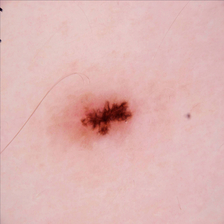

In [12]:
white_torch = torchvision.io.read_image('/content/drive/MyDrive/data_skin_cancer_detection/test/benign/1.jpg')
print("This is benign skin cancer")
T.ToPILImage()(white_torch)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This is malignant skin cancer


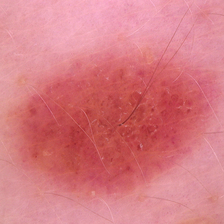

In [14]:
# Display image for reference
wh = torchvision.io.read_image('/content/drive/MyDrive/data_skin_cancer_detection/test/benign/44.jpg')
print("This is malignant skin cancer")
T.ToPILImage()(wh)

In [15]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [17]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 2077
Test dataset size: 660
Class names: ['benign', 'malignant']


In [18]:
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 512


In [20]:
model.fc = nn.Linear(num_features, 2)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0448 Acc: 72.9417% Time: 658.1845s
[Test #1] Loss: 0.0357 Acc: 79.5455% Time: 1073.3006s
Epoch 1 running
[Train #2] Loss: 0.0361 Acc: 80.6452% Time: 1096.1004s
[Test #2] Loss: 0.0330 Acc: 82.2727% Time: 1100.4103s
Epoch 2 running
[Train #3] Loss: 0.0335 Acc: 81.3674% Time: 1123.1092s
[Test #3] Loss: 0.0314 Acc: 83.3333% Time: 1127.3805s
Epoch 3 running
[Train #4] Loss: 0.0322 Acc: 81.9933% Time: 1150.4016s
[Test #4] Loss: 0.0300 Acc: 84.3939% Time: 1154.6801s
Epoch 4 running
[Train #5] Loss: 0.0321 Acc: 82.0896% Time: 1177.3751s
[Test #5] Loss: 0.0291 Acc: 83.6364% Time: 1181.7236s
Epoch 5 running
[Train #6] Loss: 0.0302 Acc: 83.0043% Time: 1204.2583s
[Test #6] Loss: 0.0307 Acc: 81.6667% Time: 1208.5995s
Epoch 6 running
[Train #7] Loss: 0.0291 Acc: 84.0636% Time: 1231.2869s
[Test #7] Loss: 0.0263 Acc: 85.4545% Time: 1235.7127s
Epoch 7 running
[Train #8] Loss: 0.0298 Acc: 84.2080% Time: 1258.4268s
[Test #8] Loss: 0.0290 Acc: 82.4242% Time: 1262.7637s
E

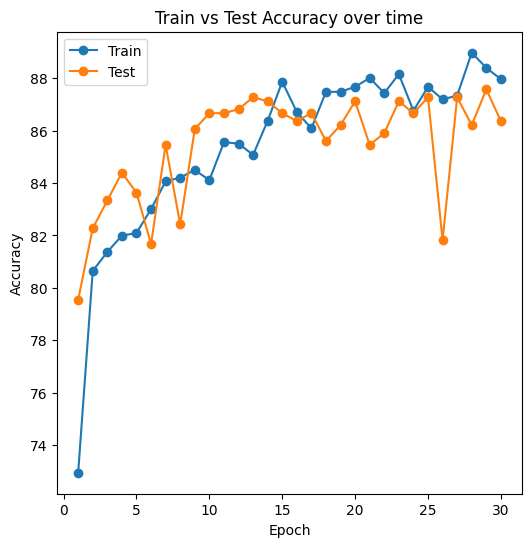

In [24]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

In [25]:
y_pred = []
y_true = []

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

Accuracy on Training set:  0.8636363636363636
Confusion matrix: 
 [[9780 1020]
 [1680 7320]]
Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     10800
           1       0.88      0.81      0.84      9000

    accuracy                           0.86     19800
   macro avg       0.87      0.86      0.86     19800
weighted avg       0.86      0.86      0.86     19800



<Axes: title={'center': 'Confusion matrix for Skin Cancer classification '}>

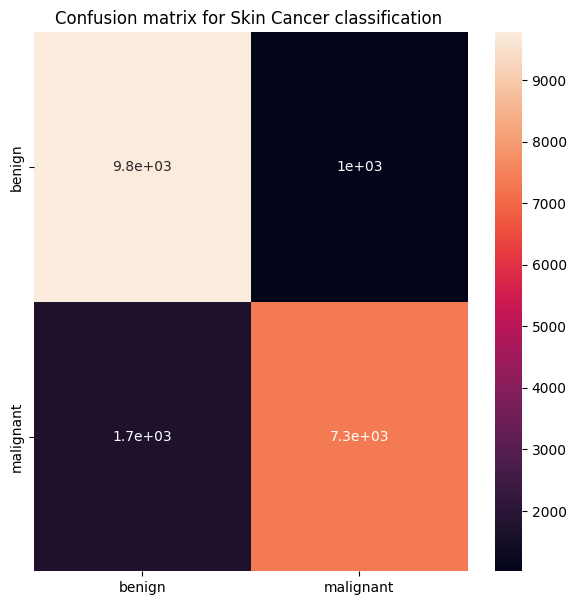

In [26]:
classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for Skin Cancer classification ")
sn.heatmap(df_cm, annot=True)